# Autodiff of an implicit function

In [3]:
import jax.numpy as jnp
from jax import grad

def f(E, e, M):
    return E - e*jnp.sin(E) - M

dfdE = grad(f, argnums=0)
dfde = grad(f, argnums=1)
dfdM = grad(f, argnums=2)


In [4]:
from functools import partial
from jax import custom_vjp
from jax.lax import while_loop


@custom_vjp
def eccentric_anomaly_newton_raphson(e, M, Eini):
    def cond_fun(carry):
        E_prev, E = carry
        return jnp.abs(E - E_prev) > 1e-6

    def body_fun(carry):
        _, E = carry
        E_new = E - f(E, e, M) / dfdE(E, e, M)
        return E, E_new

    _, E_star = while_loop(cond_fun, body_fun, (jnp.inf, Eini))
    return E_star


def eccentric_anomaly_newton_raphson_fwd(e, M, Eini):
    E_star = eccentric_anomaly_newton_raphson(e, M, Eini)
    return E_star, (jnp.sin(E_star), 1.0 - e * jnp.cos(E_star))


def eccentric_anomaly_newton_raphson_bwd(residuals, u):
    sin_E_star, one_minus_cos_E_star = residuals
    return (sin_E_star * u / one_minus_cos_E_star, u / one_minus_cos_E_star, 0.0)


eccentric_anomaly_newton_raphson.defvjp(eccentric_anomaly_newton_raphson_fwd, eccentric_anomaly_newton_raphson_bwd)

In [5]:
etest = 0.1
Mtest = 0.2
Eini = 0.3
Estar = eccentric_anomaly_newton_raphson(etest, Mtest, Eini)
print("E_star =", Estar)
dE_de = grad(eccentric_anomaly_newton_raphson, argnums=0)
dE_dM = grad(eccentric_anomaly_newton_raphson, argnums=1)


print(dE_de(etest, Mtest, Eini))
print(dE_dM(etest, Mtest, Eini))

E_star = 0.22202006
0.24400184
1.1080891


In [6]:
f(Estar, etest, Mtest)

Array(0., dtype=float32, weak_type=True)

In [27]:
from jax import jit, vmap

vmap_eccentric_anomaly = jit(vmap(eccentric_anomaly_newton_raphson, in_axes=(None, 0, 0)))
vmap_dE_de = jit(vmap(dE_de, in_axes=(None, 0, 0)))
vmap_dE_dM = jit(vmap(dE_dM, in_axes=(None, 0, 0)))

In [8]:

f(1.1*jnp.pi, 0.5, 1.1*jnp.pi)
et = 0.5
Mt =0.95*jnp.pi
def fn(E):
    return E - f(E, et, Mt) / dfdE(E, et, Mt)


E = 1.01 * jnp.pi
print(E)
for i in range(10):
    res = E - fn(E)
    E = fn(E)
    print(f"Iteration {i+1}: E = {E}", "Residual =", res)


3.173008580125691
Iteration 1: E = 3.0368523597717285 Residual = 0.13615632
Iteration 2: E = 3.036808967590332 Residual = 4.339218e-05
Iteration 3: E = 3.036808967590332 Residual = 0.0
Iteration 4: E = 3.036808967590332 Residual = 0.0
Iteration 5: E = 3.036808967590332 Residual = 0.0
Iteration 6: E = 3.036808967590332 Residual = 0.0
Iteration 7: E = 3.036808967590332 Residual = 0.0
Iteration 8: E = 3.036808967590332 Residual = 0.0
Iteration 9: E = 3.036808967590332 Residual = 0.0
Iteration 10: E = 3.036808967590332 Residual = 0.0


In [28]:
etest = 0.9
M_values = jnp.linspace(0, 2*jnp.pi-0.001, 100)
#M_values = jnp.linspace(1.1*jnp.pi, 2*jnp.pi, 10)

#M_values = jnp.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6])
E_stars = vmap_eccentric_anomaly(etest, M_values, M_values)
dE_stardM = vmap_dE_dM(etest, M_values, M_values)
#print("E_stars for M_values =", E_stars)

In [23]:
M_values[::5]

Array([0.        , 0.31728208, 0.63456416, 0.95184624, 1.2691283 ,
       1.5864104 , 1.9036925 , 2.2209744 , 2.5382566 , 2.8555388 ,
       3.1728208 , 3.4901028 , 3.807385  , 4.124667  , 4.441949  ,
       4.759231  , 5.0765133 , 5.3937955 , 5.7110777 , 6.0283594 ],      dtype=float32)

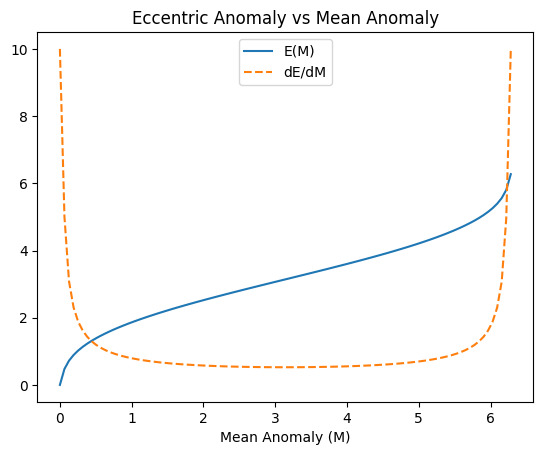

In [32]:
if False:
        from PyAstronomy import pyasl
        ks = pyasl.MarkleyKESolver()
        E_pyasl = []
        for Meach in M_values:
                E_pyasl.append(ks.getE(Meach, etest))
        E_pyasl = jnp.array(E_pyasl)

import matplotlib.pyplot as plt
import numpy as np
plt.plot(M_values, E_stars, label ='E(M)')
plt.plot(M_values, dE_stardM, label ='dE/dM', ls="--")

#plt.plot(M_values, E_pyasl, ls="dashed",label='PyAstronomy')
plt.xlabel('Mean Anomaly (M)')
plt.title('Eccentric Anomaly vs Mean Anomaly')
plt.legend()
plt.savefig("eccanom.png", dpi=300, bbox_inches='tight')
plt.show()